In [46]:
!pip install --user --upgrade --editable gym-env

Obtaining file:///home/nibir/cs698r/project/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 1.0.0
    Uninstalling gym-env-1.0.0:
      Successfully uninstalled gym-env-1.0.0
  Running setup.py develop for gym-env


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import time
import gym
import math
import pickle
SEEDS = [12, 42, 33, 55, 66, 77]

%matplotlib inline

In [2]:
def argmax(q_values):
    top_value = float("-inf")
    ties = []
    for i in range(len(q_values)):
        val = q_values[i]
        if val > top_value:
            top_value = val
            ties = [i]
            continue
        elif val == top_value:
            ties.append(i)
    return np.random.choice(ties)

In [3]:
def greedy(net, state):
    with torch.no_grad():
        q_values = net(state).detach().numpy().squeeze()
    return np.argmax(q_values)

In [4]:
class decaying_epsilon_greedy():
    def __init__(self, init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp'):
        self.epsilon = init_epsilon
        self.final_epsilon = final_epsilon
        self.max_steps = max_steps
        self.eps_list=np.zeros(max_steps)
        lamda = 0.003
        for n in range(max_steps):
            if decay_type=='lin':
                self.eps_list[n] = ((final_epsilon - init_epsilon)*n + max_steps*init_epsilon)/max_steps
            else:
                self.eps_list[n] = (init_epsilon-final_epsilon)*np.exp(-n*lamda) + final_epsilon
        self.n = 0

    def update(self):
        if self.n >= self.max_steps: 
            self.epsilon = self.final_epsilon
        else:
            self.epsilon = self.eps_list[self.n]
        self.n += 1
        return self.epsilon

    def select_action(self, net, state):
        with torch.no_grad():
            q_values = net(state).detach().numpy().squeeze()
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(len(q_values))
        else:
            action = argmax(q_values)
        self.update()
        return action

In [5]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, activation):
        super(ValueNetwork, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x

In [17]:
class ReplayBuffer():
    def __init__(self, max_size, batch_size):
        self.max_size = max_size
        self.batch_size = batch_size
        self.id = 0
        self.size = 0
        self.states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards = np.empty(shape=(max_size), dtype=np.ndarray)
        self.next_states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.dones = np.empty(shape=(max_size), dtype=np.ndarray)

    def store(self, experience):
        state, action, reward, next_state, done = experience
        self.states[self.id] = state
        self.actions[self.id] = action
        self.rewards[self.id] = reward
        self.next_states[self.id] = next_state
        self.dones[self.id] = done
        self.id = (self.id + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        ids = np.random.choice(self.size, self.batch_size, replace=False)
        experiences = torch.from_numpy(np.vstack(self.states[ids])).float(), torch.from_numpy(np.vstack(self.actions[ids])).long(), torch.from_numpy(np.vstack(self.rewards[ids])).float(), torch.from_numpy(np.vstack(self.next_states[ids])).float(), torch.from_numpy(np.vstack(self.dones[ids])).float()
        return experiences

In [19]:
class DDQN():
    def __init__(self, env, seed, gamma, MAX_TRAIN_EPISODES, optimizer, optimizer_LR, training_strategy, evaluation_strategy, update_frequency):
        self.env = env
        self.gamma = gamma
        self.env.seed(seed)
        torch.manual_seed(seed)
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
        self.nn_online = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.nn_target = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.optimizer = optimizer(self.nn_online, optimizer_LR)
        self.training_strategy = training_strategy()
        self.evaluation_strategy = evaluation_strategy
        self.update_frequency = update_frequency

    def train_network(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        max_actions = self.nn_online(next_states).max(1)[1]
        Q_next = self.nn_target(next_states).detach()
        max_Q_next = Q_next[np.arange(len(dones)), max_actions].unsqueeze(1)
        td_target = rewards + (self.gamma * max_Q_next * (1 - dones))
        Q_curr = self.nn_online(states).gather(1, actions)
        td_error = td_target - Q_curr
        loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.nn_online.parameters(), 1e7)
        self.optimizer.step()
    
    def update_network(self):
        for target, online in zip(self.nn_target.parameters(), self.nn_online.parameters()):
            target.data.copy_(online.data)

    def train_agent(self):
        start_train = time.time()
        self.train_rewards = []
        self.eval_rewards = []    
        self.update_network()
        result = np.empty((self.MAX_TRAIN_EPISODES, 2))
        for episode in range(self.MAX_TRAIN_EPISODES):
            state, done = self.env.reset()
            self.train_rewards.append(0.0)
            while not done:
                action = self.training_strategy.select_action(self.nn_online, state)
                next_state, reward, done, _ = self.env.step(action)
                experience = (state, action, reward, next_state, float(done))
                self.replay_buffer.store(experience)
                self.train_rewards[-1] += reward
                if self.replay_buffer.size > self.replay_buffer.batch_size * 5:
                    experiences = self.replay_buffer.sample()
                    self.train_network(experiences)
                if episode % self.update_frequency == 0:
                    self.update_network()
                state = next_state
            eval_reward = self.evaluate()
            self.eval_rewards.append(eval_reward)
            mov_mean_train_reward = np.mean(self.train_rewards[-100:])
            mov_mean_eval_reward = np.mean(self.eval_rewards[-100:])
            result[episode] = mov_mean_train_reward, mov_mean_eval_reward
            elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_train))
            if episode<self.MAX_TRAIN_EPISODES-1:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}", end='\r')
            else:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}")
 
                
        print('TRAINING DONE')
        return result
    
    def evaluate(self):
        state, done = self.env.reset()
        returns = 0
        while not done:
            action = self.evaluation_strategy(self.nn_online, state)
            state, reward, done, _ = self.env.step(action)
            returns += reward
        return returns

In [20]:
ddqn_results = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v0', interval_time=10, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DDQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 10)
    result = agent.train_agent()
    ddqn_results.append(result)
ddqn_results = np.array(ddqn_results)

ELAPSED TIME: 00:04:26 EPISODES: 999 TRAIN REWARD: 282.1540913776317 EVALUATION REWARD: 82.9614474896489266
TRAINING DONE
ELAPSED TIME: 00:04:18 EPISODES: 999 TRAIN REWARD: 47.34086303714267 EVALUATION REWARD: 21.8157726895362357
TRAINING DONE
ELAPSED TIME: 00:03:53 EPISODES: 999 TRAIN REWARD: 101.10389574699477 EVALUATION REWARD: 88.229246004429139
TRAINING DONE
ELAPSED TIME: 00:03:22 EPISODES: 999 TRAIN REWARD: 100.99282972569084 EVALUATION REWARD: 91.901616470664458
TRAINING DONE
ELAPSED TIME: 00:03:11 EPISODES: 999 TRAIN REWARD: 51.70484636692422 EVALUATION REWARD: 31.8656446656578544
TRAINING DONE
ELAPSED TIME: 00:03:24 EPISODES: 999 TRAIN REWARD: 70.40439713755569 EVALUATION REWARD: 54.5909177172551454
TRAINING DONE


In [24]:
class DQN():
    def __init__(self, env, seed, gamma, MAX_TRAIN_EPISODES, optimizer, optimizer_LR, training_strategy, evaluation_strategy, update_frequency):
        self.env = env
        self.gamma = gamma
        self.env.seed(seed)
        torch.manual_seed(seed)
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
        self.nn_online = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.nn_target = ValueNetwork(6, env.action_space.n, hidden_dims=(512,128), activation=F.relu)
        self.optimizer = optimizer(self.nn_online, optimizer_LR)
        self.training_strategy = training_strategy()
        self.evaluation_strategy = evaluation_strategy
        self.update_frequency = update_frequency

    def train_network(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        max_actions = self.nn_target(next_states).max(1)[1]
        Q_next = self.nn_target(next_states).detach()
        max_Q_next = Q_next[np.arange(len(dones)), max_actions].unsqueeze(1)
        td_target = rewards + (self.gamma * max_Q_next * (1 - dones))
        Q_curr = self.nn_online(states).gather(1, actions)
        td_error = td_target - Q_curr
        loss = td_error.pow(2).mul(0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(self.nn_online.parameters(), float('inf'))
        self.optimizer.step()
    
    def update_network(self):
        for target, online in zip(self.nn_target.parameters(), self.nn_online.parameters()):
            target.data.copy_(online.data)

    def train_agent(self):
        start_train = time.time()
        self.train_rewards = []
        self.eval_rewards = []    
        self.update_network()
        result = np.empty((self.MAX_TRAIN_EPISODES, 2))
        for episode in range(self.MAX_TRAIN_EPISODES):
            state, done = self.env.reset()
            self.train_rewards.append(0.0)
            while not done:
                action = self.training_strategy.select_action(self.nn_online, state)
                next_state, reward, done, _ = self.env.step(action)
                experience = (state, action, reward, next_state, float(done))
                self.replay_buffer.store(experience)
                self.train_rewards[-1] += reward
                if self.replay_buffer.size > self.replay_buffer.batch_size:
                    experiences = self.replay_buffer.sample()
                    self.train_network(experiences)
                if episode % self.update_frequency == 0:
                    self.update_network()
                state = next_state
            eval_reward = self.evaluate()
            self.eval_rewards.append(eval_reward)
            mov_mean_train_reward = np.mean(self.train_rewards[-100:])
            mov_mean_eval_reward = np.mean(self.eval_rewards[-100:])
            result[episode] = mov_mean_train_reward, mov_mean_eval_reward
            elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_train))
            if episode<self.MAX_TRAIN_EPISODES-1:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}", end='\r', flush=True)
            else:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}")
 
                
        print('TRAINING DONE')
        return result
    
    def evaluate(self):
        state, done = self.env.reset()
        returns = 0
        while not done:
            action = self.evaluation_strategy(self.nn_online, state)
            state, reward, done, _ = self.env.step(action)
            returns += reward
        return returns

In [25]:
dqn_results = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v1', interval_time=10, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 15)
    result = agent.train_agent()
    dqn_results.append(result)
dqn_results = np.array(dqn_results)

ELAPSED TIME: 00:06:09 EPISODES: 999 TRAIN REWARD: 261.04887812522134 EVALUATION REWARD: 34.173804049191956
TRAINING DONE
ELAPSED TIME: 00:05:57 EPISODES: 999 TRAIN REWARD: 163.4954061874341 EVALUATION REWARD: 4.88685284926330671
TRAINING DONE
ELAPSED TIME: 00:06:10 EPISODES: 999 TRAIN REWARD: 298.6606260126048 EVALUATION REWARD: 150.832506777750782
TRAINING DONE
ELAPSED TIME: 00:06:36 EPISODES: 999 TRAIN REWARD: 164.05426084398965 EVALUATION REWARD: 11.6147801710968223
TRAINING DONE
ELAPSED TIME: 00:04:58 EPISODES: 999 TRAIN REWARD: 256.45813624414393 EVALUATION REWARD: 39.922421629813044
TRAINING DONE
ELAPSED TIME: 00:05:04 EPISODES: 999 TRAIN REWARD: 216.24312236905743 EVALUATION REWARD: 21.317496888660026
TRAINING DONE


In [9]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, activation=F.relu):
        super(PolicyNetwork,self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
    def forward(self, state):
        x = state
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float)
            x.unsqueeze(0)
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
    
    def select_action(self, state):
        probs = self.forward(state)
        m = torch.distributions.Categorical(logits=probs)
        action = m.sample()
        log_prob = m.log_prob(action).unsqueeze(-1)
        entropy = m.entropy().unsqueeze(-1)
        return action, log_prob, entropy
        
    def select_greedy_action(self, state):
        probs = self.forward(state)
        return argmax(probs)

In [12]:
class VPG():
    def __init__(self, env, seed, gamma, MAX_TRAIN_EPISODES, policy_optimizer, policy_LR, policy_max_grad_norm, value_optimizer, value_LR, value_max_grad_norm, beta):
        self.env = env
        self.env.seed(seed)
        torch.manual_seed(seed)
        self.gamma = gamma
        self.MAX_TRAIN_EPISODES = MAX_TRAIN_EPISODES
        self.nn_policy = PolicyNetwork(6, self.env.action_space.n, hidden_dims=(128,128), activation=F.relu)
        self.policy_optimizer = policy_optimizer(self.nn_policy, policy_LR)
        self.policy_max_grad_norm = policy_max_grad_norm
        self.nn_value = ValueNetwork(6, 1, hidden_dims=(256,256), activation=F.relu)
        self.value_optimizer = value_optimizer(self.nn_value, value_LR)
        self.value_max_grad_norm = value_max_grad_norm
        self.beta = beta
        
    def get_stepwise_returns_discounts(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])
        return torch.FloatTensor(returns).unsqueeze(1), torch.FloatTensor(discounts).unsqueeze(1)

    def train_value_policy_networks(self):
        returns, discounts = self.get_stepwise_returns_discounts()
        self.log_probs = torch.cat(self.log_probs)
        self.entropies = torch.cat(self.entropies) 
        self.values = torch.cat(self.values)
        deltas = returns - self.values
        baseline_loss = -(discounts * deltas.detach() * self.log_probs).mean()
        entropy_loss = -self.entropies.mean()
        policy_loss = baseline_loss + self.beta * entropy_loss
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.nn_policy.parameters(), self.policy_max_grad_norm)
        self.policy_optimizer.step()
        value_loss = deltas.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.nn_value.parameters(), self.value_max_grad_norm)
        self.value_optimizer.step()

    def train_agent(self):
        start_train = time.time()
        self.train_rewards = []
        self.eval_rewards = []
        self.average_rewrad = 0
        result = np.empty((self.MAX_TRAIN_EPISODES, 2))
        for episode in range(self.MAX_TRAIN_EPISODES):
            state, done = self.env.reset()
            self.train_rewards.append(0.0)
            self.log_probs, self.entropies, self.rewards, self.values = [], [], [], []
            while not done:
                action, log_prob, entropy = self.nn_policy.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.log_probs.append(log_prob)
                self.entropies.append(entropy)
                self.rewards.append(reward)
                self.values.append(self.nn_value(state))
                self.train_rewards[-1] += reward
                state=next_state
            self.train_value_policy_networks()
            eval_reward = self.eval_agent()
            self.eval_rewards.append(eval_reward)
            mov_mean_train_reward = np.mean(self.train_rewards[-100:])
            mov_mean_eval_reward = np.mean(self.eval_rewards[-100:])
            result[episode] = mov_mean_train_reward, mov_mean_eval_reward
            elapsed_time = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_train))
            if episode<self.MAX_TRAIN_EPISODES-1:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}", end='\r', flush=True)
            else:
                print(f"ELAPSED TIME: {elapsed_time} EPISODES: {episode} TRAIN REWARD: {mov_mean_train_reward} EVALUATION REWARD: {mov_mean_eval_reward}")
 
                
        print('TRAINING DONE')
        return result
    
    def eval_agent(self):
        state, done = self.env.reset()
        returns = 0
        while not done:
            action = self.nn_policy.select_greedy_action(state)
            state, reward, done, _ = self.env.step(action)
            returns += reward
        return returns

In [13]:
vpg_results = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v0', interval_time=10, total_time=4)
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_LR = 0.0005
    policy_max_grad_norm = 1
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_LR = 0.0007
    value_max_grad_norm = float('inf')
    beta = 0.001
    agent = VPG(env, seed, 1.00, 1000, policy_optimizer, policy_LR, policy_max_grad_norm, value_optimizer, value_LR, value_max_grad_norm, beta)
    result = agent.train_agent()
    vpg_results.append(result)
vpg_results = np.array(vpg_results)

ELAPSED TIME: 00:02:05 EPISODES: 999 TRAIN REWARD: 574.3125672633078 EVALUATION REWARD: 579.316744138205444
TRAINING DONE
ELAPSED TIME: 00:02:17 EPISODES: 999 TRAIN REWARD: 576.8694477714641 EVALUATION REWARD: 581.584974301909564
TRAINING DONE
ELAPSED TIME: 00:02:20 EPISODES: 999 TRAIN REWARD: 577.2851156803132 EVALUATION REWARD: 579.459755419900644
TRAINING DONE
ELAPSED TIME: 00:02:23 EPISODES: 999 TRAIN REWARD: 573.2681213639079 EVALUATION REWARD: 575.129863717909354
TRAINING DONE
ELAPSED TIME: 00:02:28 EPISODES: 999 TRAIN REWARD: 572.555674835615 EVALUATION REWARD: 578.6306251674579244
TRAINING DONE
ELAPSED TIME: 00:02:23 EPISODES: 999 TRAIN REWARD: 552.847076962993 EVALUATION REWARD: 563.0242106541463127
TRAINING DONE


In [41]:
ddqn_train_mean_10, ddqn_eval_mean_10 = np.mean(ddqn_results, axis=0).T
dqn_train_mean_10, dqn_eval_mean_10 = np.mean(dqn_results, axis=0).T
vpg_train_mean_10, vpg_eval_mean_10 = np.mean(vpg_results, axis=0).T

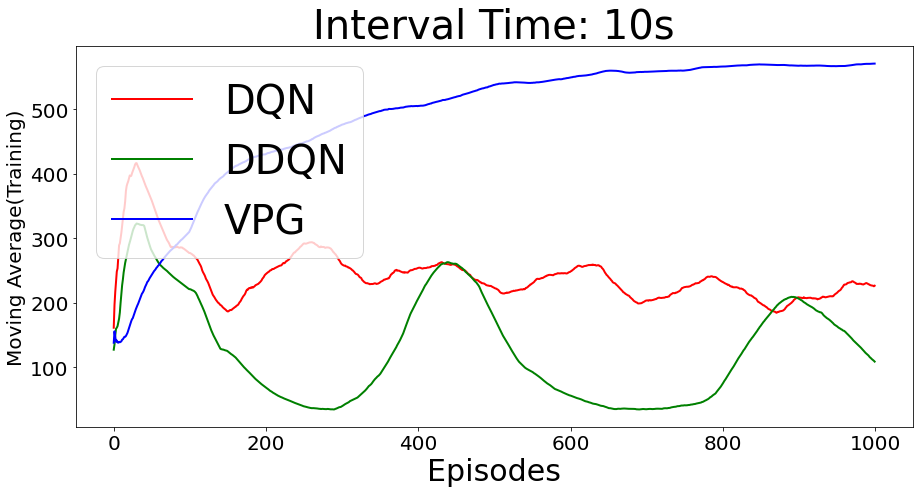

In [45]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_train_mean_10, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_train_mean_10, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_train_mean_10, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Training)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 10s', fontsize=40)
plt.savefig('deep_3.pdf')

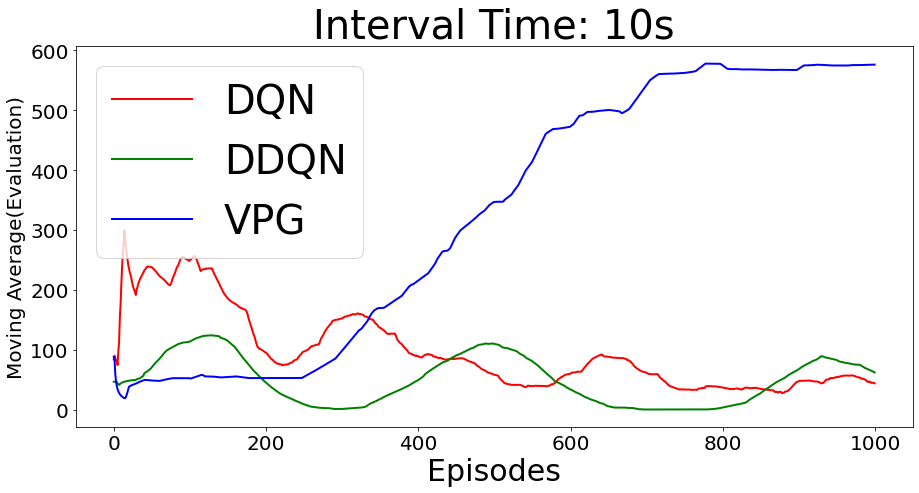

In [44]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_eval_mean_10, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_eval_mean_10, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_eval_mean_10, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Evaluation)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 10s', fontsize=40)
plt.savefig('deep_4.pdf')

In [35]:
ddqn_results_1 = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v0', interval_time=3, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DDQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 10)
    result = agent.train_agent()
    ddqn_results_1.append(result)
ddqn_results_1 = np.array(ddqn_results_1)

ELAPSED TIME: 00:16:04 EPISODES: 999 TRAIN REWARD: 98.115485906939 EVALUATION REWARD: 0.0.00265467514176403
TRAINING DONE
ELAPSED TIME: 00:17:53 EPISODES: 999 TRAIN REWARD: 466.0542684749491 EVALUATION REWARD: 246.085630712897348
TRAINING DONE
ELAPSED TIME: 00:16:11 EPISODES: 999 TRAIN REWARD: 93.30193592030496 EVALUATION REWARD: 0.06996196134462398
TRAINING DONE
ELAPSED TIME: 00:15:28 EPISODES: 999 TRAIN REWARD: 108.65053371156748 EVALUATION REWARD: 0.0258163987562219
TRAINING DONE
ELAPSED TIME: 00:11:29 EPISODES: 999 TRAIN REWARD: 231.7304785269282 EVALUATION REWARD: 164.729411958534547
TRAINING DONE
ELAPSED TIME: 00:11:38 EPISODES: 999 TRAIN REWARD: 255.16317595038257 EVALUATION REWARD: 171.20766716257214
TRAINING DONE


In [36]:
dqn_results_1 = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v0', interval_time=3, total_time=4)
    optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    training_strategy = lambda: decaying_epsilon_greedy(init_epsilon=1.0, final_epsilon=0.3, max_steps=20000, decay_type='exp')
    evaluation_strategy = lambda net, state: greedy(net, state)
    agent = DQN(env, seed, 0.99, 1000, optimizer , 0.0007, training_strategy, evaluation_strategy, 15)
    result = agent.train_agent()
    dqn_results_1.append(result)
dqn_results_1 = np.array(dqn_results_1)

ELAPSED TIME: 05:58:26 EPISODES: 999 TRAIN REWARD: 93.41046277374149 EVALUATION REWARD: 0.00938878105911465
TRAINING DONE
ELAPSED TIME: 00:09:02 EPISODES: 999 TRAIN REWARD: 95.08433689687661 EVALUATION REWARD: 0.00986395222280448
TRAINING DONE
ELAPSED TIME: 00:08:40 EPISODES: 999 TRAIN REWARD: 92.36977146963032 EVALUATION REWARD: 0.07155645568449472
TRAINING DONE
ELAPSED TIME: 00:08:11 EPISODES: 999 TRAIN REWARD: 93.84957101167967 EVALUATION REWARD: 0.03634860717834822
TRAINING DONE
ELAPSED TIME: 00:07:52 EPISODES: 999 TRAIN REWARD: 93.82030255136686 EVALUATION REWARD: 0.00298760702236678
TRAINING DONE
ELAPSED TIME: 00:08:04 EPISODES: 999 TRAIN REWARD: 90.00009098802052 EVALUATION REWARD: 0.02677428686697659
TRAINING DONE


In [37]:
vpg_results_1 = []
for seed in SEEDS:
    env = gym.make('gym_env:foraging-v0', interval_time=3, total_time=4)
    policy_optimizer = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    policy_LR = 0.0005
    policy_max_grad_norm = 1
    value_optimizer = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_LR = 0.0007
    value_max_grad_norm = float('inf')
    beta = 0.001
    agent = VPG(env, seed, 1.00, 1000, policy_optimizer, policy_LR, policy_max_grad_norm, value_optimizer, value_LR, value_max_grad_norm, beta)
    result = agent.train_agent()
    vpg_results_1.append(result)
vpg_results_1 = np.array(vpg_results_1)

ELAPSED TIME: 00:02:52 EPISODES: 999 TRAIN REWARD: 897.4577711646853 EVALUATION REWARD: 903.864120958248665
TRAINING DONE
ELAPSED TIME: 00:03:08 EPISODES: 999 TRAIN REWARD: 902.8891587135538 EVALUATION REWARD: 904.46931434914896
TRAINING DONE
ELAPSED TIME: 00:03:07 EPISODES: 999 TRAIN REWARD: 902.2048502395404 EVALUATION REWARD: 904.00121115846935
TRAINING DONE
ELAPSED TIME: 00:03:03 EPISODES: 999 TRAIN REWARD: 904.4867188632713 EVALUATION REWARD: 760.794418953815251
TRAINING DONE
ELAPSED TIME: 00:03:07 EPISODES: 999 TRAIN REWARD: 900.5872303456333 EVALUATION REWARD: 803.02781599921634
TRAINING DONE
ELAPSED TIME: 00:03:08 EPISODES: 999 TRAIN REWARD: 885.6611257017155 EVALUATION REWARD: 677.63863101026583
TRAINING DONE


In [38]:
ddqn_train_mean, ddqn_eval_mean = np.mean(ddqn_results_1, axis=0).T
dqn_train_mean, dqn_eval_mean = np.mean(dqn_results_1, axis=0).T
vpg_train_mean, vpg_eval_mean = np.mean(vpg_results_1, axis=0).T

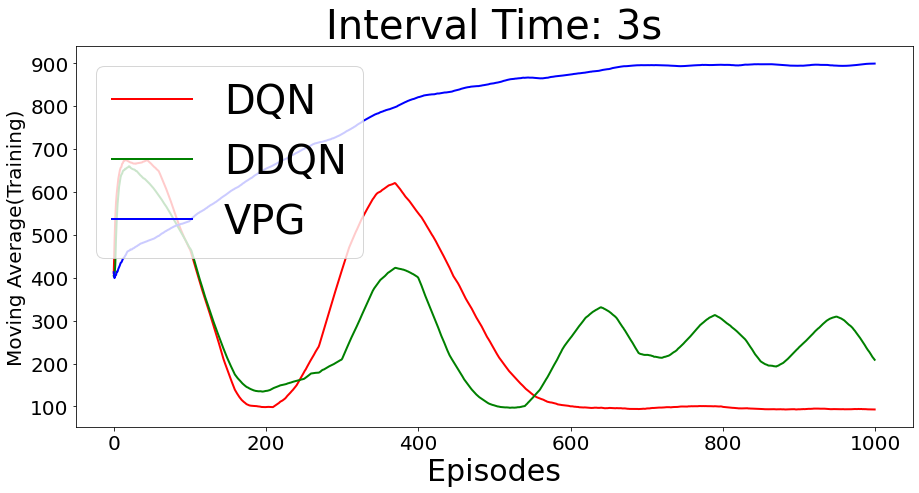

In [46]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_train_mean, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_train_mean, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_train_mean, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Training)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 3s', fontsize=40)
plt.savefig('deep_7.pdf')

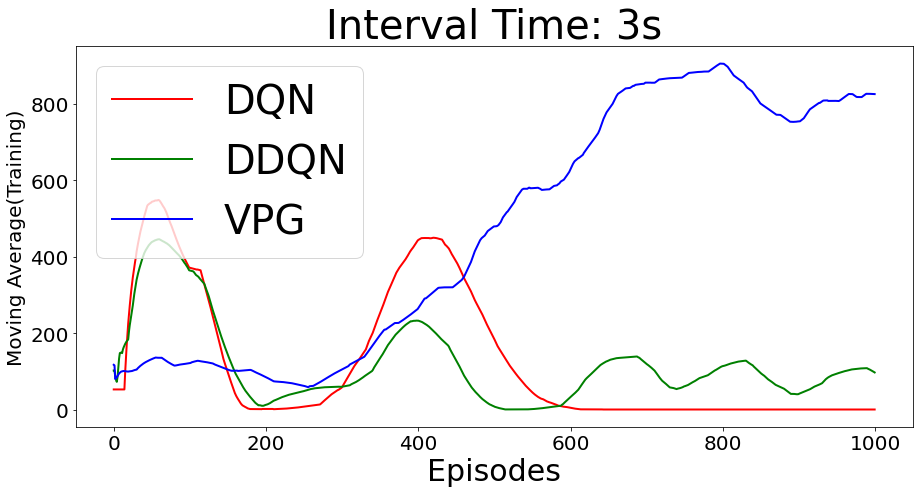

In [47]:
#Plots for moving rewards training
fig, axs = plt.subplots(1, 1, figsize=(15,7))
plt.plot(dqn_eval_mean, 'r', label='DQN', linewidth=2)
plt.plot(ddqn_eval_mean, 'g', label='DDQN', linewidth=2)
plt.plot(vpg_eval_mean, 'b', label='VPG', linewidth=2)

plt.legend(fontsize=40, loc='upper left')
plt.ylabel('Moving Average(Training)', fontsize=20)
plt.xlabel('Episodes', fontsize=30)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Interval Time: 3s', fontsize=40)
plt.savefig('deep_8.pdf')

In [61]:
file_name = "dqn_simple.pkl"

open_file = open(file_name, "wb")
pickle.dump(dqn_results, open_file)
open_file.close()

In [60]:
file_name = "ddqn_simple.pkl"

open_file = open(file_name, "wb")
pickle.dump(ddqn_results, open_file)
open_file.close()

In [59]:
file_name = "vpg_simple.pkl"

open_file = open(file_name, "wb")
pickle.dump(vpg_results, open_file)
open_file.close()

In [58]:
file_name = "dqn_simple_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(dqn_results_1, open_file)
open_file.close()

In [56]:
file_name = "ddqn_simple_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(ddqn_results_1, open_file)
open_file.close()

In [57]:
file_name = "vpg_simple_1.pkl"

open_file = open(file_name, "wb")
pickle.dump(vpg_results_1, open_file)
open_file.close()